<h1><center>Thruster Performance Analysis</center></h1>

## 1. Introduction

### Objective
The purpose of this notebook is to analyze and evaluate experimental thruster performance data in order to estimate key propulsion parameters such as specific impulse (Isp), characteristic velocity (C*), thrust coefficient (Cf), total impulse, and combustion efficiency.
We also investigate transient response times (T90, T10), thermal response, and feedline dynamics.

---

### Context
The dataset comes from a steady-state thruster test campaign and includes:  
- **Time (s)**  
- **Chamber Pressure (Bar)**  
- **Feedline Pressures (Bar)** – 4 channels  
- **Mass Flow Rate (g/s)**  
- **Solenoid Valve Feedback (V)**  
- **Thermocouple Temperatures (°C)** – 5 sensors  
- **Thrust (N)**  

These measurements are used to evaluate injector behavior, combustion performance, and overall thruster efficiency.

---

### Deliverables
This notebook will produce:  
- **Isp (Specific Impulse):** Instantaneous values and steady-state average  
- **C\*** (Characteristic Velocity) and **C\* % Efficiency**  
- **Total Impulse (I_total):** With effective Isp  
- **Thermal Response:** Average/peak temperatures, rise times, stability (thermocouples)  
- **Feedline Dynamics:** Feedline vs chamber pressure, injector pressure drop (ΔP)  
- **Transient Response:** Valve event detection, T90 (rise time), T10 (decay time)  
- **Visualization Outputs:**  
  - Time vs Chamber Pressure (with T90, T10 annotations)  
  - Time vs Thrust  
  - Time vs Mass Flow Rate  
  - Time vs Valve Signal  
  - Time vs Thermocouple Temperatures (all sensors, clearly labeled)  
  - Isp vs Time  
  - Cf vs Time  
  - C\* vs Time  

---

## 2. Import and Data Cleaning

### Module Imports

In [7]:
# --- Imports ---
import pandas as pd
import numpy as np
import filedialpy as fp  # pip install filedialpy
import matplotlib.pyplot as plt

# pip install rocketcea  -- install rocketcea package
from rocketcea.cea_obj_w_units import CEA_Obj  # for theoretical C*

---

### Data Import
- Load the experimental dataset (`Steady State Assignment Dataset.xlsx`).  
- Preview the first few rows to confirm structure and column names.

In [10]:
# --- Load dataset ---
df = pd.read_excel(fp.openFile())  # choose Steady State Assignment Dataset.xlsx

# Preview first rows
print("First 5 rows of dataset:")
df.head()

First 5 rows of dataset:


,TIME,Feedline 1 (Bar),Feedline 2 (Bar),Feedline 3 (Bar),Feedline 4 (Bar),Chamber Pressure (Bar),Mass Flow Rate (g/sec),Thrust (N),Solenoid Valve Feedback,Thermocouple 1,Thermocouple 2,Thermocouple 3,Thermocouple 4,Thermocouple 5
0,0.001,28.6622,28.7330,28.733,28.7684,0.0708,-0.151984,-0.0354,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362
1,0.002,28.6622,28.7330,28.733,28.7566,0.0708,-0.155996,-0.0354,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362
2,0.003,28.6740,28.7330,28.733,28.7566,0.0708,-0.160008,-0.0354,0.1652,55.3066,128.5374,213.7688,361.9532,281.5362
3,0.004,28.6740,28.7330,28.733,28.7566,0.0708,-0.164020,-0.0354,0.1298,55.3066,128.5374,213.7688,361.9532,281.5362
4,0.005,28.6740,28.7448,28.733,28.7566,0.0708,-0.168032,-0.0354,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362


In [11]:
# --- Column names ---
print("Columns in dataset:")
df.columns

Columns in dataset:


Index(['TIME', 'Feedline 1 (Bar)', 'Feedline 2 (Bar)', 'Feedline 3  (Bar)',
       'Feedline 4 (Bar)', 'Chamber Pressure (Bar)', 'Mass Flow Rate (g/sec)',
       'Thrust (N)', 'Solenoid Valve Feedback', ' Thermocouple 1',
       ' Thermocouple 2', ' Thermocouple 3', ' Thermocouple 4',
       ' Thermocouple 5'],
      dtype='object')

---

### Descriptive Statistics
- Generate descriptive statistics (mean, min, max, standard deviation) for all columns.  
- Helps to quickly check the data range, identify outliers, and validate sensor readings.

In [14]:
# --- Descriptive statistics ---
print("Descriptive statistics:")
df.describe()

Descriptive statistics:


,TIME,Feedline 1 (Bar),Feedline 2 (Bar),Feedline 3 (Bar),Feedline 4 (Bar),Chamber Pressure (Bar),Mass Flow Rate (g/sec),Thrust (N),Solenoid Valve Feedback,Thermocouple 1,Thermocouple 2,Thermocouple 3,Thermocouple 4,Thermocouple 5
count,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000,104900.000000
mean,52.450500,28.401614,28.384049,28.312057,28.140254,15.208051,0.477529,0.760400,13.199393,58.528354,114.462258,196.705068,772.884633,446.088457
std,30.282166,0.142655,0.144254,0.147631,0.152648,2.364761,0.111353,0.133623,1.775114,2.036779,5.049667,5.386730,124.006077,69.864545
min,0.001000,28.143000,28.095800,27.907000,27.741800,-0.708000,-0.333232,-0.082600,0.000000,55.094200,109.244400,192.835600,352.218200,255.245800
25%,26.225750,28.308200,28.284600,28.213800,28.036800,15.351800,0.470230,0.767000,13.404800,56.675400,111.156000,193.378400,758.421400,423.419400
50%,52.450500,28.343600,28.331800,28.249200,28.072200,15.623200,0.474360,0.790600,13.440200,59.047200,112.501200,194.003800,821.055800,475.020800
75%,78.675250,28.485200,28.461600,28.379000,28.202000,15.930000,0.479434,0.802400,13.463800,60.687400,117.410000,197.473000,842.744200,491.694200
max,104.900000,28.921800,28.969000,28.898200,28.792000,18.419800,1.730942,0.967600,13.723400,60.852600,128.537400,213.792400,873.235400,523.259200


---

### Data Quality Check
1. **Check for Missing Values:** Identify null entries.  
2. **Negative Values:** Replace negative values in *Mass Flow Rate* and *Thrust* with 0 (since they are not physically meaningful).  
3. **Unit Conversions:**  
   - Mass Flow Rate → convert from g/s to kg/s.  
4. **Valve Event Detection:** Use solenoid valve feedback to determine `t_open` and `t_close`.  
5. **Steady-State Mask:** Exclude transient start/end by trimming a short period after valve open and before valve close.  

#### After these steps, the dataset is clean and ready for performance calculations.

In [16]:
# --- Check for missing values ---
df.isna().sum()

TIME                       0
Feedline 1 (Bar)           0
Feedline 2 (Bar)           0
Feedline 3  (Bar)          0
Feedline 4 (Bar)           0
Chamber Pressure (Bar)     0
Mass Flow Rate (g/sec)     0
Thrust (N)                 0
Solenoid Valve Feedback    0
 Thermocouple 1            0
 Thermocouple 2            0
 Thermocouple 3            0
 Thermocouple 4            0
 Thermocouple 5            0
dtype: int64

#### Data Cleaning

In [18]:
# Replace negative values in Mass Flow Rate and Thrust
df['Mass Flow Rate (g/sec)'] = df['Mass Flow Rate (g/sec)'].clip(lower=0)
df['Thrust (N)'] = df['Thrust (N)'].clip(lower=0)

print('Observe the Mass Flow rate and Thrust columns')
df.head(1500)

Observe the Mass Flow rate and Thrust columns


,TIME,Feedline 1 (Bar),Feedline 2 (Bar),Feedline 3 (Bar),Feedline 4 (Bar),Chamber Pressure (Bar),Mass Flow Rate (g/sec),Thrust (N),Solenoid Valve Feedback,Thermocouple 1,Thermocouple 2,Thermocouple 3,Thermocouple 4,Thermocouple 5
0,0.001,28.6622,28.7330,28.7330,28.7684,0.0708,0.000000,0.0000,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362
1,0.002,28.6622,28.7330,28.7330,28.7566,0.0708,0.000000,0.0000,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362
2,0.003,28.6740,28.7330,28.7330,28.7566,0.0708,0.000000,0.0000,0.1652,55.3066,128.5374,213.7688,361.9532,281.5362
3,0.004,28.6740,28.7330,28.7330,28.7566,0.0708,0.000000,0.0000,0.1298,55.3066,128.5374,213.7688,361.9532,281.5362
4,0.005,28.6740,28.7448,28.7330,28.7566,0.0708,0.000000,0.0000,0.1534,55.3066,128.5374,213.7688,361.9532,281.5362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.496,28.7802,28.6386,28.6504,28.6032,12.9328,0.557904,0.6962,13.4992,55.3184,128.4784,213.7806,360.8204,280.7220
1496,1.497,28.7802,28.6386,28.6386,28.6032,12.9328,0.558258,0.7080,13.4992,55.3184,128.4784,213.7806,360.8204,280.7220
1497,1.498,28.7920,28.6386,28.6386,28.6032,12.9210,0.558494,0.7080,13.4638,55.3184,128.4784,213.7806,360.8204,280.7220
1498,1.499,28.7920,28.6386,28.6386,28.6032,12.9092,0.558848,0.7080,13.4638,55.3184,128.4784,213.7806,360.8204,280.7220


In [19]:
# Convert mass flow rate from g/s to kg/s
df['Mass Flow Rate (kg/sec)'] = df['Mass Flow Rate (g/sec)'] / 1000

print('Mass Flow Rate (kg/sec)')
df['Mass Flow Rate (kg/sec)']

Mass Flow Rate (kg/sec)


0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
104895    0.000006
104896    0.000005
104897    0.000005
104898    0.000005
104899    0.000005
Name: Mass Flow Rate (kg/sec), Length: 104900, dtype: float64

#### Valve Event Detection - Opening and Closing time

In [21]:
valve_signal = df['Solenoid Valve Feedback']
time = df['TIME']

# Threshold midway between min and max voltage
threshold = (valve_signal.min() + valve_signal.max()) / 2

# First index above threshold → valve open
open_idx = np.argmax(valve_signal > threshold)
# Last index above threshold → valve close
close_idx = len(valve_signal) - np.argmax((valve_signal[::-1] > threshold)) - 1

# Open/close times
t_open = time.iloc[open_idx]
t_close = time.iloc[close_idx]

print('Valve open time:', t_open, 's')
print('Valve open time:', t_close, 's')

Valve open time: 1.0269999999999977 s
Valve open time: 104.0160000001326 s


#### Define Steady-State Region

In [23]:
settle_time = 0.2 # buffer time to remove transients
steady_mask = (time > (t_open + settle_time)) & (time < (t_close - settle_time))
steady_df = df[steady_mask]

print('Steady-state window: {:.3f} s to {:.3f} s'.format(steady_df['TIME'].iloc[0], steady_df['TIME'].iloc[-1]))

Steady-state window: 1.228 s to 103.816 s


---

## 3. Data Analysis and Results

## Part 1: Performance Parameter Extraction

### 1. Specific Impulse (Isp) 

Average Isp (steady state): 165.40 s


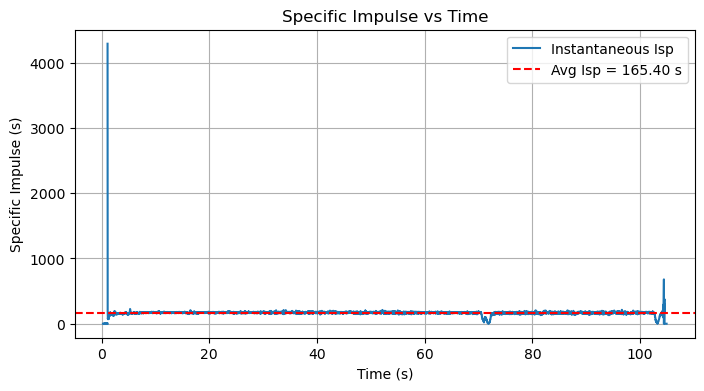

In [28]:
g = 9.81 # m/s^2 (gravitational constant)

# --- Specific Impulse Calculation ---
df['Specific Impulse (Isp)'] = df ['Thrust (N)'] / (df['Mass Flow Rate (kg/sec)'] * g)

# Average Isp in steady state
Isp_avg = df.loc[steady_mask, 'Specific Impulse (Isp)'].mean()
print(f'Average Isp (steady state): {Isp_avg:.2f} s')

# --- Visualization: Isp over time ---
plt.figure(figsize=(8,4))
plt.plot(df['TIME'], df['Specific Impulse (Isp)'], label='Instantaneous Isp')
plt.axhline(Isp_avg, color='r', linestyle='--', label=f'Avg Isp = {Isp_avg:.2f} s')
plt.xlabel('Time (s)')
plt.ylabel('Specific Impulse (s)')
plt.title('Specific Impulse vs Time')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The instantaneous Isp fluctuates during valve transients.  
- The steady-state average Isp is **165.4 s**.  
- This indicates stable combustion after ~0.2 s.

---

### 2. C* % (Combustion Efficiency)

In [32]:
# --- Theoretical characteristic velocity C* using RocketCEA ---
# --- Propellant combination ---
ox_name   = 'N2O'       # Oxidizer: Nitrous Oxide
fuel_name = 'C2H5OH'    # Fuel: Ethanol (chemical formula)

# --- Mixture ratio (O/F) and chamber pressure ---
OF_ratio  = 6.0         # Typical oxidizer-to-fuel ratio for N2O/ethanol tests
Pc_bar    = steady_df['Chamber Pressure (Bar)'].mean()  # Avg chamber pressure from dataset (bar)

## --- CEA object ---
cea = CEA_Obj(oxName=ox_name, fuelName=fuel_name)  # RocketCEA wrapper that interfaces with NASA CEA chemical equilibrium solver

# --- Theoretical C* using CEA ---
Cstar_theory = cea.get_Cstar(Pc=Pc_bar, MR=OF_ratio)

# --- Experimental C* calculation from dataset ---
# --- Experimental inputs ---
Pc_pa = df['Chamber Pressure (Bar)'].values * 1e5  # Convert Pc from bar → Pa
m_dot = df['Mass Flow Rate (kg/sec)'].values       # Mass flow rate in kg/s

# --- Nozzle throat area ---
d_t = 0.0008 # m (Nozzle throat diameter = 0.8 mm, given in problem)
A_t = np.pi * (d_t ** 2) / 4  # Circular throat area (m²)

# --- Experimental C* ---
df['Cstar_exp'] = np.full_like(m_dot, np.nan, dtype=float)  # Start with NaNs (placeholders)
mask_cstar = m_dot > 0   # Only compute where mass flow > 0
df.loc[mask_cstar, 'Cstar_exp'] = (Pc_pa[mask_cstar] * A_t) / m_dot[mask_cstar]

# --- Average experimental C* in steady state ---
Cstar_avg = df.loc[steady_mask, 'Cstar_exp'].mean()

# --- Combustion efficiency (ηC*) ---
# ηC* = (C* experimental / C* theoretical) × 100
eta_Cstar = (Cstar_avg / Cstar_theory) * 100

print(f"Average Experimental C*: {Cstar_avg:.1f} m/s")
print(f"Theoretical C*: {Cstar_theory} m/s")
print(f"Combustion Efficiency (ηC*): {eta_Cstar:.2f} %")

Average Experimental C*: 1627.3 m/s
Theoretical C*: 4951.908043858278 m/s
Combustion Efficiency (ηC*): 32.86 %


#### Observation
- The calculated combustion efficiency (ηC*) is ~32.9%, far below the values typically seen in optimized thrusters.
-  The average experimental characteristic velocity (C*) is 1627.3 m/s, which is considerably lower than the expected theoretical value for N₂O–ethanol, indicating significant combustion inefficiencies or measurement discrepancies.

---

### 3. Characteristic Velocity (C)*

Average experimental C*: 1627.3 m/s


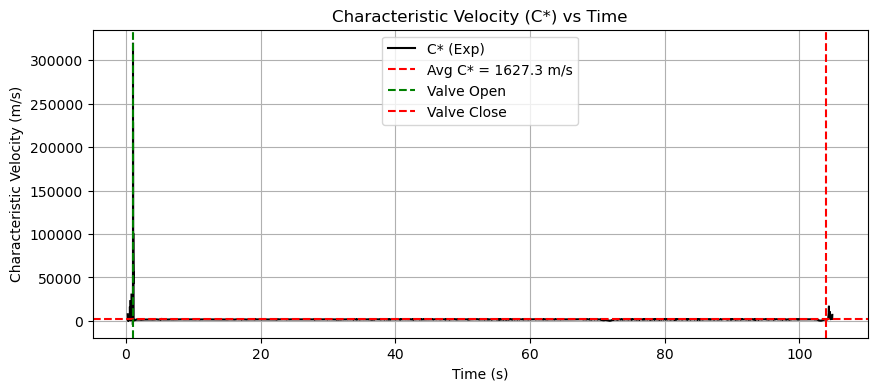

In [36]:
# --- Experimental C* --- 
print(f"Average experimental C*: {Cstar_avg:.1f} m/s")

# --- Visualization: Characteristic Velocity (C*) vs Time ---
plt.figure(figsize=(10,4))
plt.plot(df['TIME'], df['Cstar_exp'], label='C* (Exp)', color='black')
plt.axhline(Cstar_avg, color='r', linestyle='--', label=f'Avg C* = {Cstar_avg:.1f} m/s')
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')
plt.xlabel('Time (s)')
plt.ylabel('Characteristic Velocity (m/s)')
plt.title('Characteristic Velocity (C*) vs Time')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The experimental characteristic velocity was found to be 1627.3 m/s, highlighting efficiency losses when compared to theoretical expectations.

---

### 4. Total Impulse (I_total)

Valve open (t_open)  = 1.027000 s
Valve close (t_close)= 104.016000 s
Thrust baseline (pre-open mean) = 0.000000 N
Total Impulse I_total = 79.665647 N·s
Propellant consumed   = 0.050041 kg
Effective Isp (from I_total) = 162.28 s


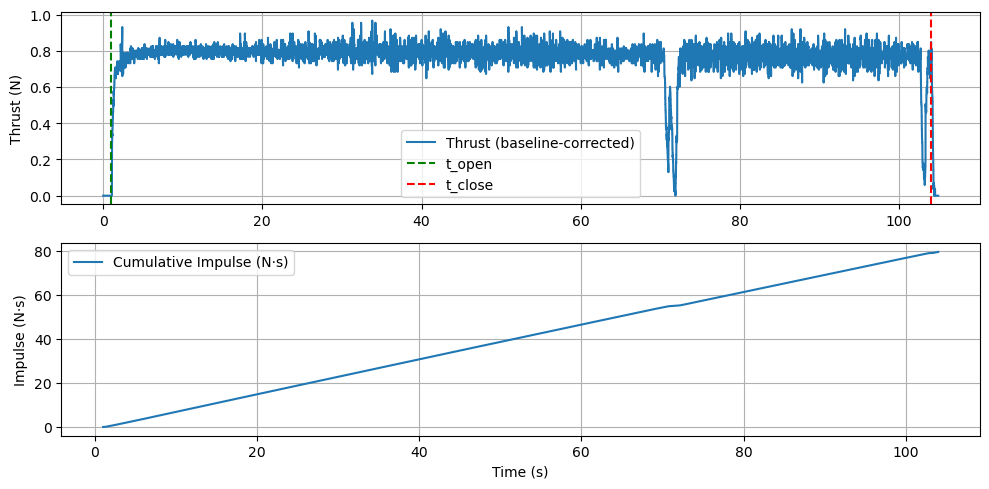

In [40]:
# --- Extracting required signals from dataset ---
time = df['TIME'].values  
thrust_raw = df['Thrust (N)'].values
massflow = df['Mass Flow Rate (kg/sec)'].values

# --- Baseline correction for thrust ---
# Computing mean thrust before valve opens (t < t_open).
# This accounts for sensor bias / noise, ensuring thrust starts at ~0.
pre_mask = time < t_open
if np.any(pre_mask):
    thrust_baseline = np.mean(thrust_raw[pre_mask])
else:
    thrust_baseline = 0.0
thrust = thrust_raw - thrust_baseline

# --- Firing window (between valve open and close) ---
fire_mask = (time >= t_open) & (time <= t_close)
t_fire = time[fire_mask]  # Time during burn
F_fire = thrust[fire_mask]  # Thrust during burn
mflow_fire = massflow[fire_mask]  # Mass flow during burn

# --- Integrating thrust to compute Total Impulse (I_total) ---
# I_total = ∫ F dt  (numerical integration using trapezoidal rule)
I_total = np.trapz(F_fire, t_fire)   # Units: N·s

# --- Integrating mass flow to compute total propellant consumed ---
# m_consumed = ∫ (ṁ) dt
m_consumed = np.trapz(mflow_fire, t_fire)  # kg

# --- Computing effective Isp from impulse ---
# Isp_eff = I_total / (m_consumed * g)
Isp_eff = I_total / (m_consumed * g) if m_consumed > 0 else np.nan

# --- Results ---
print(f"Valve open (t_open)  = {t_open:.6f} s")
print(f"Valve close (t_close)= {t_close:.6f} s")
print(f"Thrust baseline (pre-open mean) = {thrust_baseline:.6f} N")
print(f"Total Impulse I_total = {I_total:.6f} N·s")
print(f"Propellant consumed   = {m_consumed:.6f} kg")
print(f"Effective Isp (from I_total) = {Isp_eff:.2f} s")

# --- Computing cumulative impulse over time ---
# This shows how impulse builds up during the firing.
cumulative_impulse = np.cumsum(
    np.concatenate([[0], 0.5*(F_fire[1:]+F_fire[:-1]) * np.diff(t_fire)])
)

# --- Visualization: Thrust and Cumulative impulse ---
plt.figure(figsize=(10,5))

# Thrust vs Time (with valve open/close markers)
plt.subplot(2,1,1)
plt.plot(time, thrust, label='Thrust (baseline-corrected)')
plt.axvline(t_open, color='g', linestyle='--', label='t_open')
plt.axvline(t_close, color='r', linestyle='--', label='t_close')
plt.ylabel('Thrust (N)')
plt.legend()
plt.grid(True)

# Cumulative Impulse vs Time
plt.subplot(2,1,2)
plt.plot(t_fire, cumulative_impulse, label='Cumulative Impulse (N·s)')
plt.xlabel('Time (s)')
plt.ylabel('Impulse (N·s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Observation
- The thruster delivered a total impulse of ~79.7 N·s over the firing duration.
- The effective specific impulse was ~162 s.
- A total of ~0.05 kg of propellant was consumed during the test, indicating efficient propellant utilization relative to burn time.

---

### 5. Thermal Response Analysis 

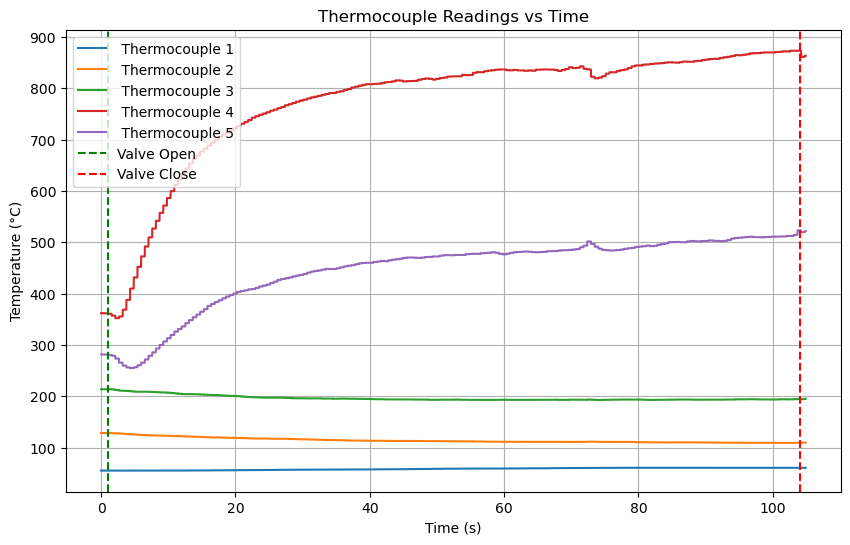


Average steady-state temperatures (°C):
 Thermocouple 1: 58.54 °C
 Thermocouple 2: 114.34 °C
 Thermocouple 3: 196.52 °C
 Thermocouple 4: 776.82 °C
 Thermocouple 5: 447.26 °C

Peak steady-state temperatures (°C):
 Thermocouple 1: 60.85 °C
 Thermocouple 2: 128.48 °C
 Thermocouple 3: 213.78 °C
 Thermocouple 4: 873.24 °C
 Thermocouple 5: 523.26 °C

Thermal rise times (time to reach 90% of peak after valve open):
 Thermocouple 1: 0.0000 s
 Thermocouple 2: 0.0000 s
 Thermocouple 3: 0.0000 s
 Thermocouple 4: 31.8230 s
 Thermocouple 5: 47.1950 s

Temperature stability (std deviation in steady state):
 Thermocouple 1: 2.02 °C
 Thermocouple 2: 4.84 °C
 Thermocouple 3: 5.11 °C
 Thermocouple 4: 116.59 °C
 Thermocouple 5: 67.86 °C


In [44]:
# --- Extracting thermocouple columns from dataset ---
thermo_cols = [col for col in df.columns if "Thermocouple" in col]

# --- Plotting thermocouple readings vs time ---
plt.figure(figsize=(10,6))
for col in thermo_cols:
    plt.plot(df['TIME'], df[col], label=col)

# --- Mark valve open and close events on the temperature plot ---
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')

plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Thermocouple Readings vs Time')
plt.legend()
plt.grid(True)
plt.show()

# --- Computing average steady-state temperature for each thermocouple ---
steady_temps = steady_df[thermo_cols].mean()

# --- Computing peak steady-state temperatures ---
peak_temps = steady_df[thermo_cols].max()

# --- Computing thermal rise times ---
# Defined as the time taken (after valve open) for each thermocouple to reach 90% of its peak steady-state temperature.
rise_times = {}
for col in thermo_cols:
    peak = steady_df[col].max()
    threshold = 0.9 * peak
    # Find first index after t_open where value exceeds threshold
    idx = df.index[(df['TIME'] >= t_open) & (df[col] >= threshold)][0]
    rise_times[col] = df['TIME'].iloc[idx] - t_open

# --- Computing stability of each thermocouple ---
stability = steady_df[thermo_cols].std()

# --- Average steady-state temperatures ---
print("\nAverage steady-state temperatures (°C):")
for col, val in steady_temps.items():
    print(f"{col}: {val:.2f} °C")

# --- Peak temperatures ---
print("\nPeak steady-state temperatures (°C):")
for col, val in peak_temps.items():
    print(f"{col}: {val:.2f} °C")

# --- Thermal rise times ---
print("\nThermal rise times (time to reach 90% of peak after valve open):")
for col, val in rise_times.items():
    print(f"{col}: {val:.4f} s")

# --- Temperature Stability (standard deviation) ---
print("\nTemperature stability (std deviation in steady state):")
for col, val in stability.items():
    print(f"{col}: {val:.2f} °C")

#### Observation
- Thermocouples show a wide temperature range, with Thermocouple 4 peaking at ~873 °C and Thermocouple 1 remaining near ~61 °C, indicating different sensor placements and heat exposure.
- Rise times confirm that sensors 1–3 respond almost immediately, while deeper sensors (4 and 5) heat up slowly, reaching 90% of peak after ~32 s and ~47 s respectively.
- Temperature stability is good for sensors 1–3 (std < 6 °C), but Thermocouples 4 and 5 exhibit large fluctuations (std deviations ~117 °C and ~68 °C), suggesting unstable thermal conditions or varying heat transfer at those points.

---

### 6. Feedline Dynamics 

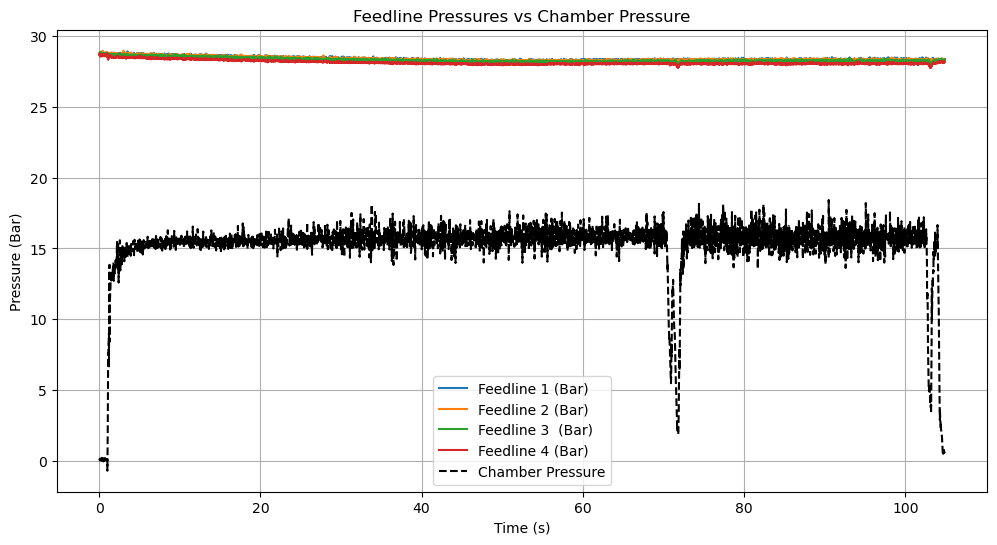


Feedline: Feedline 1 (Bar)
  Avg feedline pressure: 28.40 bar
  Avg chamber pressure : 15.47 bar
  Avg ΔP (injector drop): 12.93 bar

Feedline: Feedline 2 (Bar)
  Avg feedline pressure: 28.38 bar
  Avg chamber pressure : 15.47 bar
  Avg ΔP (injector drop): 12.91 bar

Feedline: Feedline 3  (Bar)
  Avg feedline pressure: 28.31 bar
  Avg chamber pressure : 15.47 bar
  Avg ΔP (injector drop): 12.84 bar

Feedline: Feedline 4 (Bar)
  Avg feedline pressure: 28.13 bar
  Avg chamber pressure : 15.47 bar
  Avg ΔP (injector drop): 12.66 bar


In [48]:
# --- Extracting feedline and chamber pressure columns ---
feed_cols = [col for col in df.columns if "Feedline" in col]  # All feedline pressures
chamber = df['Chamber Pressure (Bar)']
time = df['TIME']

# --- Plot feedline pressures and chamber pressure ---
plt.figure(figsize=(12,6))

# Plot each feedline pressure vs time
for col in feed_cols:
    plt.plot(time, df[col], label=col)

# Plot chamber pressure for comparison (dashed black line)
plt.plot(time, chamber, 'k--', label='Chamber Pressure')  # chamber as dashed black

plt.xlabel('Time (s)')
plt.ylabel('Pressure (Bar)')
plt.title('Feedline Pressures vs Chamber Pressure')
plt.legend()
plt.grid(True)
plt.show()

# --- Computing and print average ΔP for each feedline ---
# ΔP = Feedline pressure – Chamber pressure → injector pressure drop
for col in feed_cols:
    deltaP = df[col] - chamber
    print(f"\nFeedline: {col}")
    print(f"  Avg feedline pressure: {df.loc[steady_mask, col].mean():.2f} bar")
    print(f"  Avg chamber pressure : {chamber[steady_mask].mean():.2f} bar")
    print(f"  Avg ΔP (injector drop): {deltaP[steady_mask].mean():.2f} bar")

#### Observation
- All four feedlines maintain pressures around 28 bar, which is significantly higher than the chamber pressure (~15.5 bar).

#### Injector behavior and Pressure drops
- The injector pressure drop (ΔP) across the feedlines is consistently around 12.7–12.9 bar, showing uniform injector behavior across all channels.
- Such a large ΔP ensures good atomization and mixing, but it also indicates that a substantial portion of feedline pressure is lost across the injectors.

---

## Part 2: Transient Response (T90 and T10 Calculation)

### 1. Valve Event Detection

In [53]:
# Detecting valve open/close events from solenoid feedback
# t_open  → Time when valve first opens (signal rises above threshold)
# t_close → Time when valve closes (signal drops back below threshold)

print(f"Valve open time  (t_open): {t_open:.4f} s")  # computed earlier
print(f"Valve close time (t_close): {t_close:.4f} s")  # computed earlier

Valve open time  (t_open): 1.0270 s
Valve close time (t_close): 104.0160 s


#### Observation
- The solenoid valve opens at ~1.03 s and closes at ~104.02 s.
- This defines the burn duration (≈103 seconds), which is the time window used for steady-state and impulse calculations.

---

### 2. T90

In [57]:
time = df['TIME'].values
Pc = df['Chamber Pressure (Bar)'].values

# Compute average steady-state chamber pressure (Pc_steady)
Pc_steady = steady_df['Chamber Pressure (Bar)'].mean()

# target_90 = 90% of Pc_steady
target_90 = 0.9 * Pc_steady

# From the valve open time (t_open), finding the first time when chamber pressure ≥ target_90
mask_after_open = time >= t_open
t90 = time[mask_after_open][Pc[mask_after_open] >= target_90][0]

# T90 = (time to reach 90% Pc_steady) - (valve open time)
T90 = t90 - t_open

print(f"T90 = {T90:.3f} s")

T90 = 0.718 s


#### Observation
- The T90 rise time is 0.718 s, meaning the chamber reaches 90% of its steady-state pressure less than a second after the valve opens.
- This indicates a fast pressure buildup and quick combustion chamber pressurization, showing good injector response and propellant ignition.

---

### 3. T10

In [61]:
# target_10 = 10% of average steady-state chamber pressure
target_10 = 0.1 * Pc_steady

# From the valve close time (t_close), find the first time when chamber pressure falls below target_10
mask_after_close = time >= t_close
t10 = time[mask_after_close][Pc[mask_after_close] <= target_10][0]

# T10 = (time when pressure drops to 10% Pc_steady) - (valve close time)
T10 = t10 - t_close

print(f"T10 = {T10:.3f} s")

T10 = 0.552 s


#### Observation
- The T10 value is 0.552 s, which means the chamber pressure drops to just 10% of its steady level in about half a second after valve closure.

---

## Part 3: Visualizations and Graphs

### 1. Time vs Chamber Pressure (annotated with T90 and T10) 

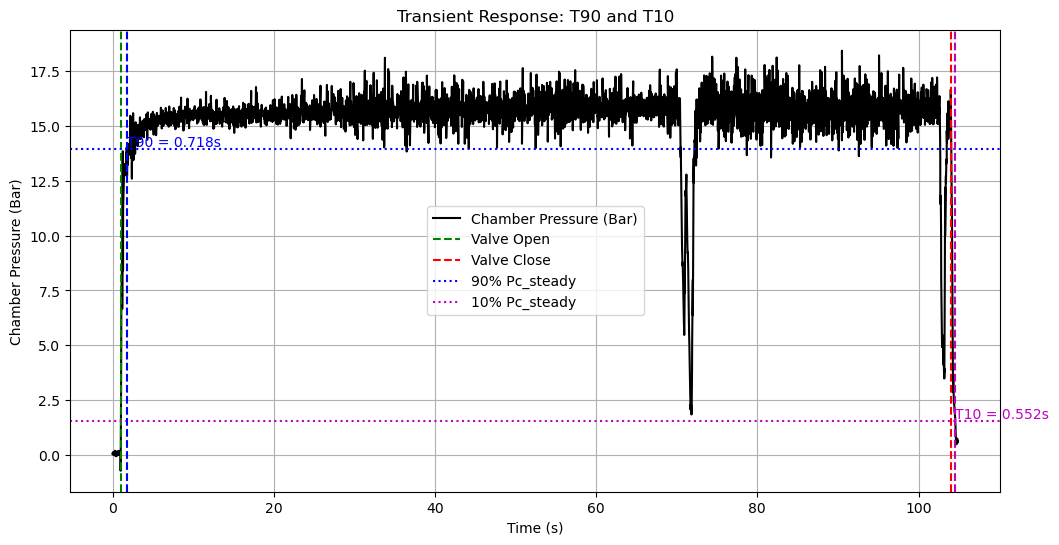

T90 = 0.718 s, T10 = 0.552 s


In [66]:
plt.figure(figsize=(12,6))

# --- Plot chamber pressure vs time ---
plt.plot(time, Pc, label='Chamber Pressure (Bar)', color='black')

# --- Mark valve open and close times ---
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')

# --- Add steady-state reference lines (90% and 10% of Pc_steady) ---
plt.axhline(target_90, color='b', linestyle=':', label='90% Pc_steady')
plt.axhline(target_10, color='m', linestyle=':', label='10% Pc_steady')

# --- Mark T90 (time to reach 90% Pc after valve open) ---
plt.axvline(t90, color='b', linestyle='--')
plt.text(t90, target_90, f"T90 = {T90:.3f}s", color='b', va='bottom')

# --- Mark T10 (time to drop to 10% Pc after valve close) ---
plt.axvline(t10, color='m', linestyle='--')
plt.text(t10, target_10, f"T10 = {T10:.3f}s", color='m', va='bottom')

# --- Labels and plot settings ---
plt.xlabel('Time (s)')
plt.ylabel('Chamber Pressure (Bar)')
plt.title('Transient Response: T90 and T10')
plt.legend()
plt.grid(True)
plt.show()

# --- Final values ---
print(f"T90 = {T90:.3f} s, T10 = {T10:.3f} s")

#### Observation
- The T90 rise time is 0.718 s, meaning the chamber reaches 90% of steady-state pressure in less than a second after valve opening. This indicates a fast pressurization and efficient ignition response.
- The T10 decay time is 0.552 s, showing that the chamber pressure drops rapidly after valve closure, which reflects quick depressurization and valve shutoff effectiveness.

---

### 2. Time vs Experimental Thrust 

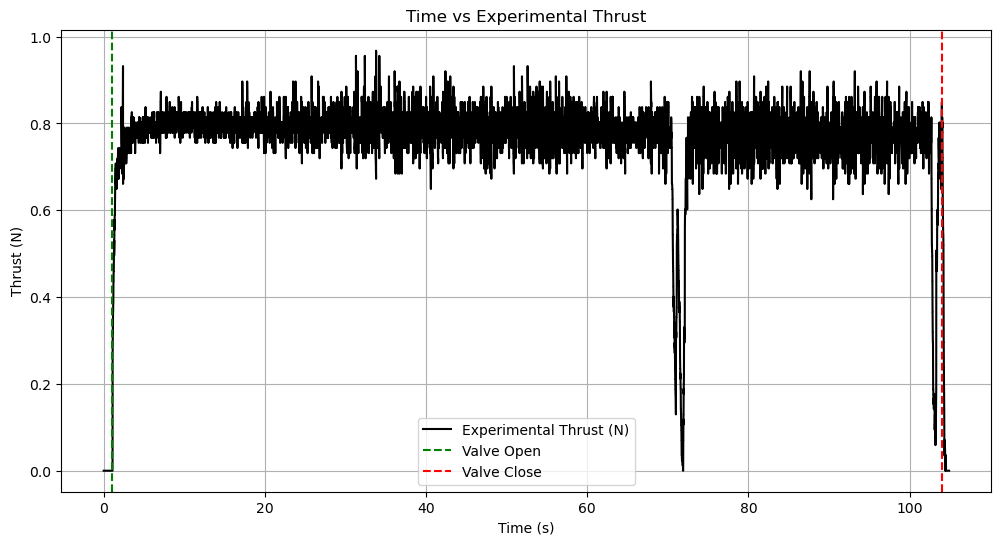

In [70]:
plt.figure(figsize=(12,6))

# --- Plot experimental thrust vs time ---
plt.plot(time, thrust, label='Experimental Thrust (N)', color='black')

# --- Mark valve opening and closing events ---
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')

plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.title('Time vs Experimental Thrust')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The thrust builds up rapidly after the valve opens, stabilizing around 0.8 N during steady-state operation.
- Small oscillations and fluctuations are present, which could be due to injector dynamics or measurement noise.
- After valve closure, the thrust drops sharply to near zero, indicating effective shutdown response of the thruster.

---

### 3. Time vs Mass Flow Rate

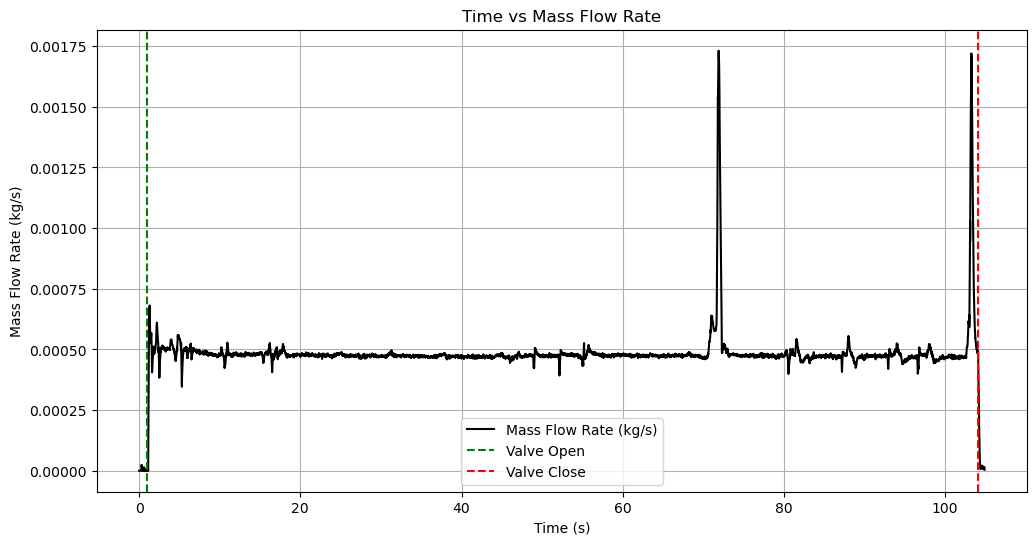

In [74]:
# --- Extract mass flow rate data from dataset ---
mflow = df['Mass Flow Rate (kg/sec)'].values

plt.figure(figsize=(12,6))

# --- Plot mass flow rate vs time ---
plt.plot(time, mflow, label='Mass Flow Rate (kg/s)', color='black')

# --- Mark valve opening and closing times ---
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')

plt.xlabel('Time (s)')
plt.ylabel('Mass Flow Rate (kg/s)')
plt.title('Time vs Mass Flow Rate')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The mass flow rate rises sharply at valve opening, stabilizing around 0.0005 kg/s during steady-state operation.
- Two noticeable spikes occur mid-test and near shutdown, suggesting transient flow disturbances or injector pulsing.
- After the valve closes, the mass flow rate quickly drops to zero, showing proper cutoff behavior.

---

### 4. Time vs Valve Voltage Feedback

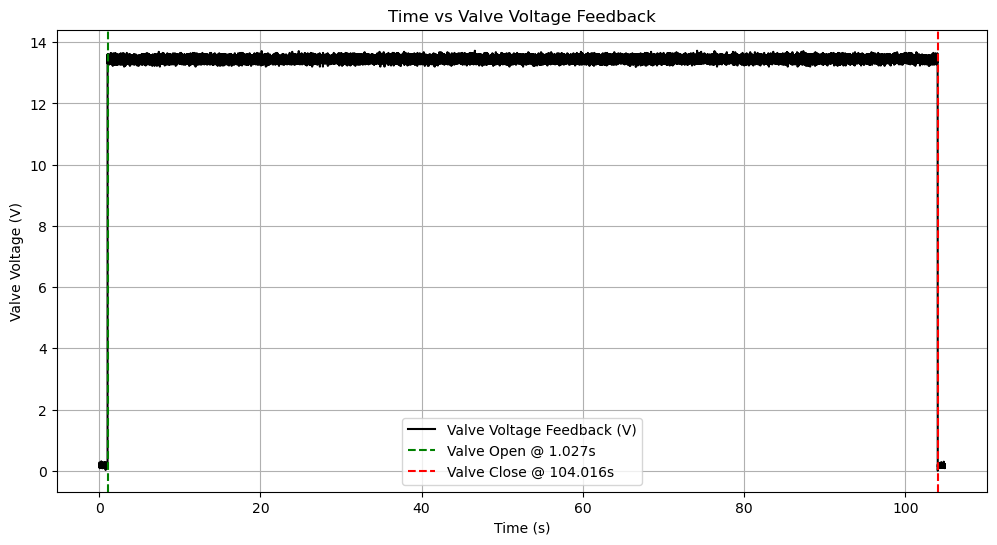

In [78]:
# --- Extract solenoid valve feedback signal ---
valve = df['Solenoid Valve Feedback'].values

plt.figure(figsize=(12,6))

# --- Extract solenoid valve feedback signal ---
plt.plot(time, valve, label='Valve Voltage Feedback (V)', color='black')

# --- Mark valve opening and closing times ---
plt.axvline(t_open, color='g', linestyle='--', label=f'Valve Open @ {t_open:.3f}s')
plt.axvline(t_close, color='r', linestyle='--', label=f'Valve Close @ {t_close:.3f}s')

plt.xlabel('Time (s)')
plt.ylabel('Valve Voltage (V)')
plt.title('Time vs Valve Voltage Feedback')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The solenoid valve feedback signal is near 0 V before opening and after closing.
- When the valve opens at t ≈ 1.027 s, the signal jumps to around 13–14 V, indicating the valve remained energized throughout the test.
- At t ≈ 104.016 s, the signal drops back to 0 V, confirming valve closure.
- The flat high signal during the firing confirms the valve behaved consistently without oscillations or dropouts.

---

### 5. Time vs Thermocouple Temperatures (all sensors, clearly labelled)

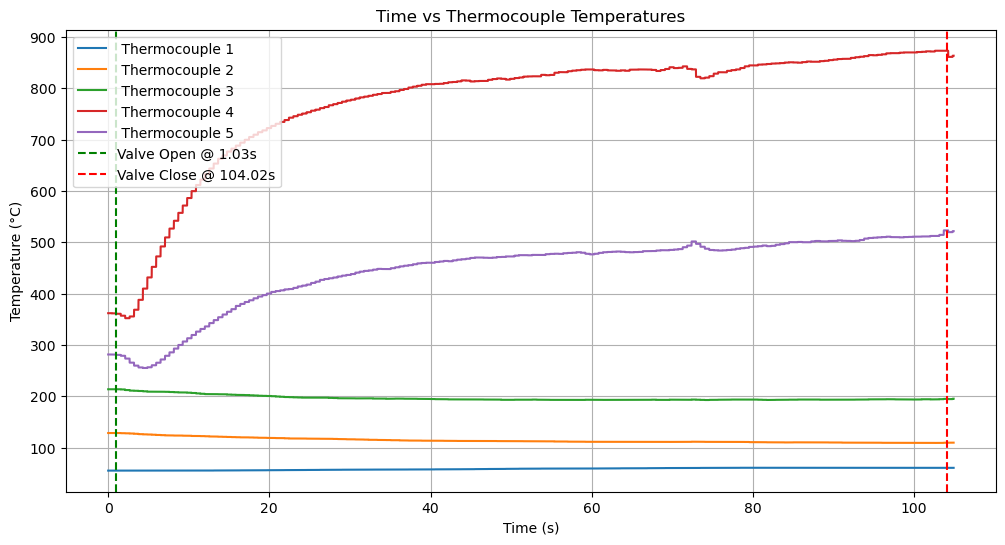

In [82]:
plt.figure(figsize=(12,6))

# --- Plot thermocouple temperature data over time ---
for col in thermo_cols:
    plt.plot(time, df[col], label=col)

# --- Mark valve open and close times for reference ---
plt.axvline(t_open, color='g', linestyle='--', label=f'Valve Open @ {t_open:.2f}s')
plt.axvline(t_close, color='r', linestyle='--', label=f'Valve Close @ {t_close:.2f}s')

plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Time vs Thermocouple Temperatures')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- The thermocouples show different heating patterns depending on their locations.
- Thermocouple 4 records the highest temperature (~870 °C), indicating it is closest to the combustion zone.
- Thermocouples 1–3 remain relatively low (50–200 °C), suggesting they are farther from the flame or better insulated.
- Thermocouple 5 reaches ~520 °C, showing intermediate heating compared to TC4.
- After valve closure, the temperatures plateau, indicating residual heat retention in the chamber.

---

### 6. Specific Impulse vs Time 

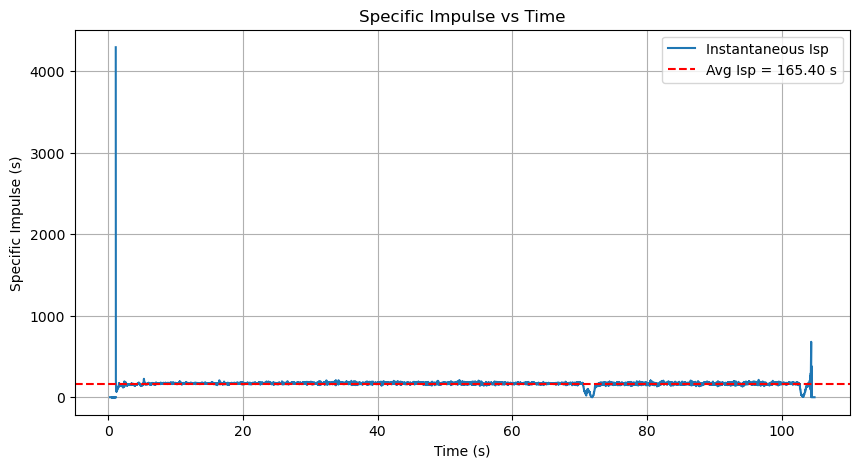

In [86]:
plt.figure(figsize=(10,5))

# --- Plot instantaneous Isp over time ---
plt.plot(df['TIME'], df['Specific Impulse (Isp)'], label='Instantaneous Isp')

# --- Add average Isp as a horizontal reference line ---
plt.axhline(Isp_avg, color='r', linestyle='--', label=f'Avg Isp = {Isp_avg:.2f} s')

plt.xlabel('Time (s)')
plt.ylabel('Specific Impulse (s)')
plt.title('Specific Impulse vs Time')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
- Instantaneous Isp fluctuates at startup and shutdown due to transients.
- It stabilizes around ~165.4 s during steady operation.
- Start-up spike comes from valve opening; end dips from valve closure.
- Overall, Isp `~165 s` is lower than theoretical `~250+ s`.

---

### 7. Plots of Cf and C* vs Time 

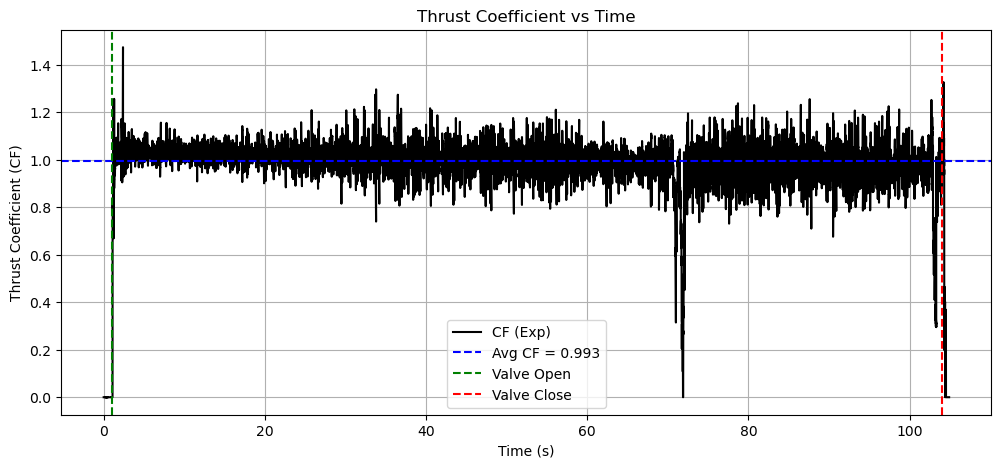

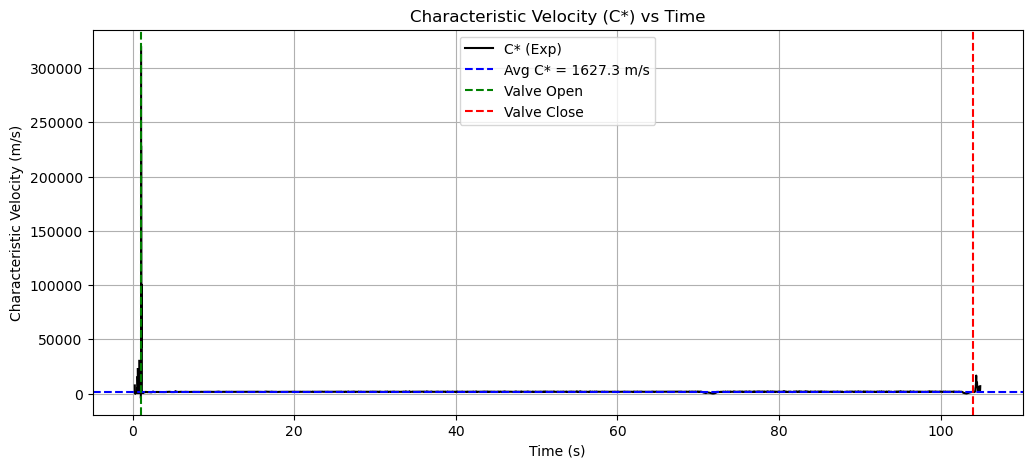

Average CF (steady state): 0.993
Average C* (steady state): 1627.3 m/s


In [90]:
F = df['Thrust (N)'].values

# --- Compute CF safely ---
df['CF_exp'] = np.full_like(F, np.nan, dtype=float)
mask_cf = Pc_pa > 0
df.loc[mask_cf, 'CF_exp'] = F[mask_cf] / (Pc_pa[mask_cf] * A_t)

# --- Averages in steady state ---
CF_avg = df.loc[steady_mask, 'CF_exp'].mean()

# --- Plot CF ---
plt.figure(figsize=(12,5))
plt.plot(time, df['CF_exp'], label='CF (Exp)', color='black')
plt.axhline(CF_avg, color='b', linestyle='--', label=f'Avg CF = {CF_avg:.3f}')
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')
plt.xlabel('Time (s)')
plt.ylabel('Thrust Coefficient (CF)')
plt.title('Thrust Coefficient vs Time')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot C* ---
plt.figure(figsize=(12,5))
plt.plot(time, df['Cstar_exp'], label='C* (Exp)', color='black')
plt.axhline(Cstar_avg, color='b', linestyle='--', label=f'Avg C* = {Cstar_avg:.1f} m/s')
plt.axvline(t_open, color='g', linestyle='--', label='Valve Open')
plt.axvline(t_close, color='r', linestyle='--', label='Valve Close')
plt.xlabel('Time (s)')
plt.ylabel('Characteristic Velocity (m/s)')
plt.title('Characteristic Velocity (C*) vs Time')
plt.legend()
plt.grid(True)
plt.show()

# --- Results ---
print(f"Average CF (steady state): {CF_avg:.3f}")
print(f"Average C* (steady state): {Cstar_avg:.1f} m/s")

#### Observation
- The average thrust coefficient (CF ≈ 0.993) is close to unity, which is expected for small-scale thrusters, suggesting nozzle performance is near ideal but with slight inefficiencies.
- The average characteristic velocity (C* ≈ 1627 m/s) is much lower than theoretical values for N₂O–ethanol (~4800–5000 m/s), indicating poor combustion efficiency.
- The plots show large transient spikes at startup/shutdown, but steady-state values remain relatively stable.
- Overall, while nozzle performance appears acceptable (CF near 1), the low C* highlights incomplete combustion or poor propellant mixing.

---

## 4. Key Results

### Valve Events
- **Open time:** ~1.027 s  
- **Close time:** ~104.016 s  
- **Steady-state window:** ~1.2 s → 103.8 s  

---

### Chamber Pressure Transients
- **T90 (rise):** 0.718 s → fast pressurization  
- **T10 (decay):** 0.552 s → rapid depressurization after closure  

---

### Characteristic Velocity (C\*)
- **Experimental C\* (avg):** 1627.3 m/s  
- **Theoretical C\* (CEA):** ~4952 m/s  
- **Efficiency (ηC\*):** ~32.9% → significantly lower than typical 90–98%  

---

### Thrust & Impulse
- **Total Impulse (I_total):** 79.7 N·s  
- **Propellant consumed:** 0.050 kg  
- **Effective Isp:** ~162.3 s  

---

### Specific Impulse vs Time
- Strong fluctuations at startup/shutdown  
- **Steady-state avg Isp:** ~165.4 s  
- Lower than theoretical (~250 s for N₂O–ethanol)  

---

### Thrust Coefficient (Cf)
- **Avg Cf (steady):** ~0.993  
- Close to ideal (1.0) → nozzle performing as expected  

---

### Feedline Dynamics
- **Feedline pressures:** ~28.3–28.4 bar  
- **Chamber pressure:** ~15.5 bar  
- **Injector ΔP:** ~12.7–12.9 bar  
- Large ΔP ensures atomization but also indicates pressure losses  

---

### Thermal Response (Thermocouples)
- **Avg steady temperatures:** ~59 °C → ~777 °C  
- **Peak values:** up to ~873 °C (near combustion zone)  
- **Rise times:** TC4 ~32 s, TC5 ~47 s (slowest)  
- **Stability:** chamber wall thermocouples show larger fluctuations

---

## 5. Final Conclusions

- The thruster operated stably over ~100 s with consistent chamber pressure and thrust.  
- **Transient response:** very good (T90 < 1 s, T10 < 1 s).  
- **C\* efficiency (~33%)** is much lower than expected → suggests incomplete combustion, poor mixing, or measurement losses.  
- **Isp (~165 s):** within experimental N₂O–ethanol range but below theoretical (~250+ s).  
- **Injector ΔP (~13 bar):** ensures atomization but may be excessive, wasting pressure.  
- **Thermocouples:** confirm correct heating distribution with hottest near combustion zone and slower heating at outer walls.  

Overall, the thruster test shows **good stability and injector behavior**, but **significant performance losses** (low C\* efficiency and Isp) suggest incomplete combustion or unoptimized propellant mixing.